Librerie

Questa cella importa tutte le librerie necessarie per l'elaborazione dei dati, la modellazione, la valutazione e la visualizzazione. Includiamo librerie per gestire lo sbilanciamento delle classi (SMOTE), la validazione incrociata per serie temporali (TimeSeriesSplit) e modelli avanzati come XGBoost. Gli avvisi sono soppressi per un output più pulito, e le impostazioni di seaborn/matplotlib sono regolate per una migliore visualizzazione.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import LearningCurve
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)
%matplotlib inline

**Caricamento e Pulizia dei Dati**


Carichiamo il dataset `london_weather.csv`, assumendo che si trovi nella stessa directory. I valori mancanti nelle colonne numeriche vengono riempiti con la loro media per evitare di eliminare righe. La colonna `date` viene convertita in formato datetime per l'elaborazione temporale.

In [ ]:
# Caricamento dei dati
data = pd.read_csv("london_weather.csv", delimiter=';', encoding='ISO-8859-1')  # Modifica il percorso se necessario

# Informazioni sul dataset
print("Colonne del dataset:", data.columns)
data.info()
data.head()

Colonne del dataset: Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [ ]:
# Gestione dei valori mancanti con la media per le colonne numeriche
columns_to_fill = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth"]
for col in columns_to_fill:
    data[col] = data[col].fillna(data[col].mean())

# Conversione della data in formato datetime
data['date'] = pd.to_datetime(data['date'], format="%Y%m%d")
data.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


 **Pulizia dei Dati**

Gestiamo i valori mancanti nelle colonne numeriche riempiendoli con la media, come nel tuo codice. Controlliamo anche i duplicati per completezza

In [ ]:
# Gestione dei valori mancanti
columns_to_fill = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth"]
for col in columns_to_fill:
    data[col] = data[col].fillna(data[col].mean())

# Controllo duplicati
print("Numero di duplicati:", data.duplicated().sum())

Numero di duplicati: 0


 **Feature Engineering**

Estraiamo giorno, mese e anno dalla colonna `date` per catturare pattern stagionali. Aggiungiamo una feature di lag per la precipitazione (precipitazione del giorno precedente) e creiamo variabili dummy per il mese. Creiamo la variabile target binaria `y` (0: nessuna pioggia, 1: pioggia). Infine, ordiniamo il dataset per data per rispettare l'ordine temporale.

In [ ]:
# Conversione data
data['date'] = pd.to_datetime(data['date'], format="%Y%m%d")

# Estrazione feature
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Feature di lag
data['precip_lag1'] = data['precipitation'].shift(1).fillna(0)

# Dummy per mese
data = pd.get_dummies(data, columns=['month'], prefix='month')

# Target binario
data['y'] = [0 if x == 0 else 1 for x in data['precipitation']]

# Ordinamento
data = data.sort_values('date')


**Analisi di Correlazione (Heatmap)**

Visualizziamo la heatmap di correlazione per identificare feature altamente correlate, come nel tuo codice. Questo aiuta a decidere quali feature droppare.

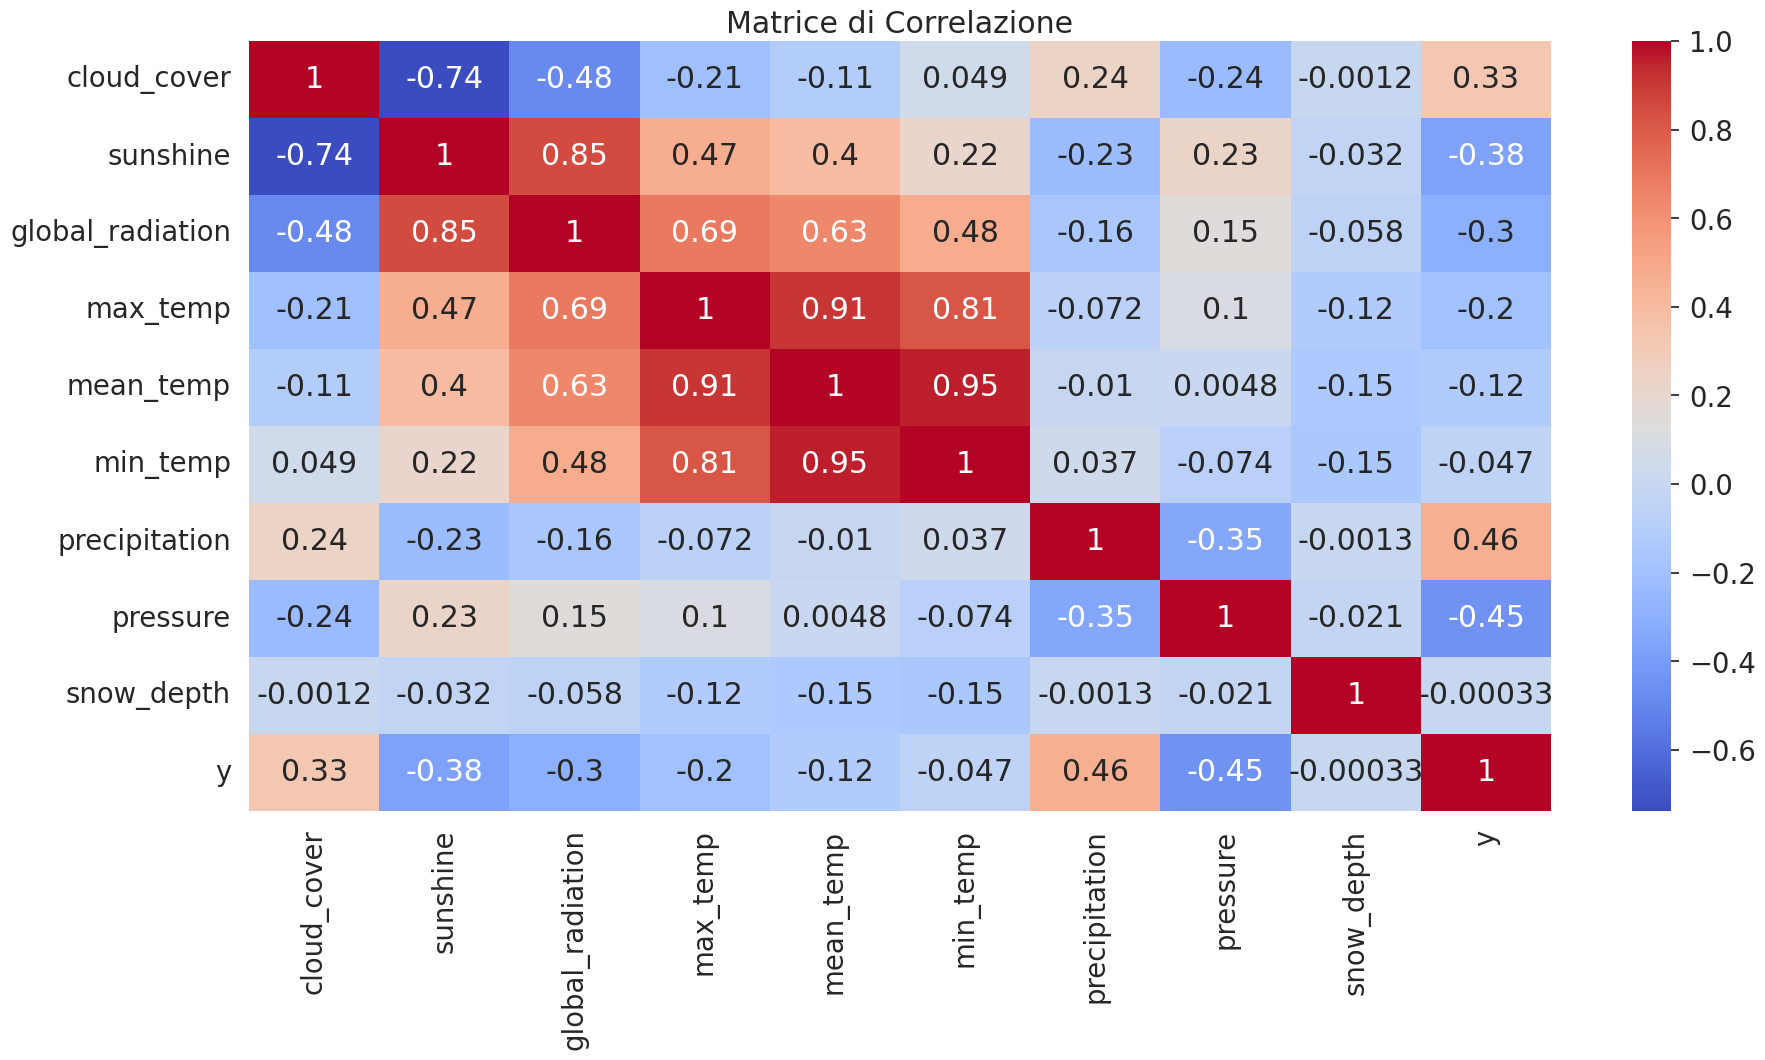

In [ ]:
# Heatmap di correlazione
plt.figure(figsize=(21, 10))
sns.heatmap(data[columns_to_fill + ['y']].corr(), annot=True, cmap='coolwarm')
plt.title("Matrice di Correlazione")
plt.show()

 **Selezione delle Feature**

Selezioniamo le feature numeriche, incluse le nuove feature di lag e le dummy dei mesi. Droppiamo le feature altamente correlate (come `max_temp`, `mean_temp`, `min_temp`, `global_radiation`) per evitare multicollinearità, come identificato nell'analisi precedente. Definiamo le feature (X) e il target (y).

In [ ]:
# Selezione delle feature
numerical_columns = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp',
                     'pressure', 'snow_depth', 'precip_lag1', 'day'] + [col for col in data.columns if col.startswith('month_')]

# Rimozione feature correlate
numerical_columns = [col for col in numerical_columns if col not in ['max_temp', 'mean_temp', 'min_temp', 'global_radiation']]

# Feature e target
X = data[numerical_columns]
y = data['y']

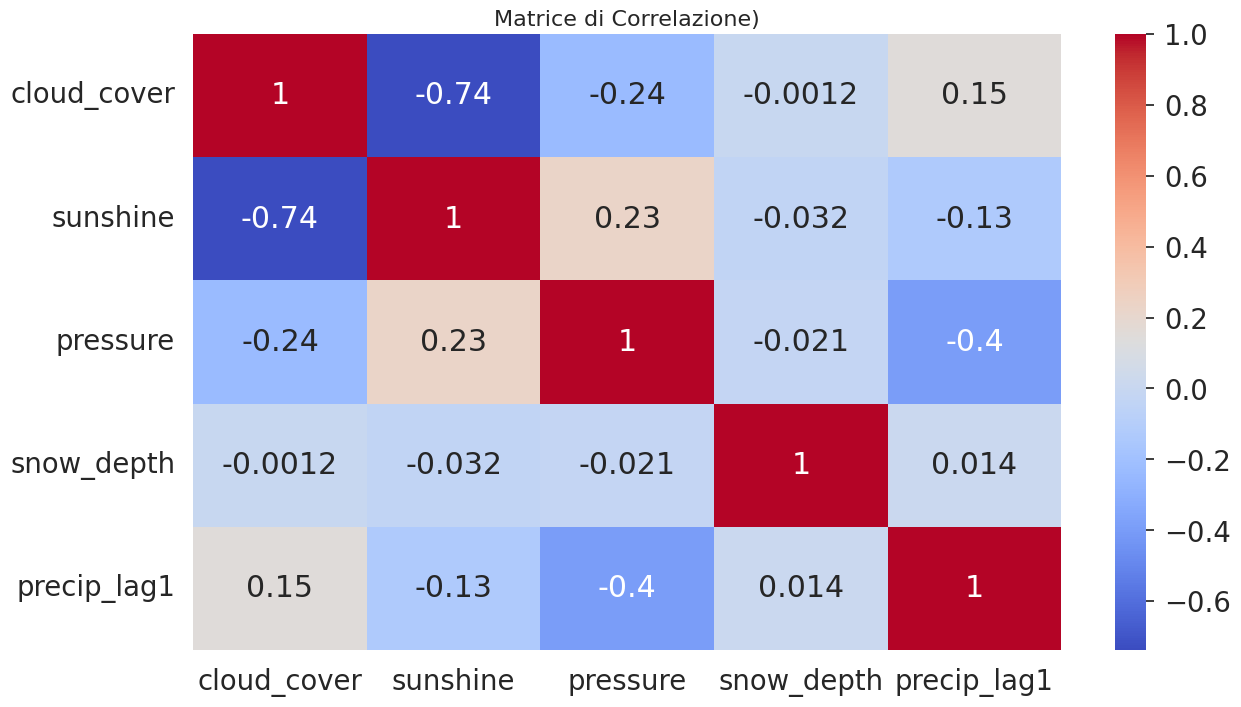

In [ ]:
# Seleziono solo le colonne numeriche, escludendo mesi, day e target y
num_only = [
    col for col in numerical_columns
    if not col.startswith('month_') and not col.startswith('day') and col != 'y'
]

plt.figure(figsize=(14, 8))
sns.heatmap(data[num_only].corr(), annot=True, cmap='coolwarm')
plt.title("Matrice di Correlazione)", fontsize=16)
plt.show()





 **Divisione Temporale del Dataset**

Dividiamo il dataset in training (fino al 2018) e test (2019-2020) per rispettare la natura temporale dei dati. Questo evita il data leakage che si verifica con una divisione casuale.

In [ ]:
# Split temporale
train_mask = data['year'] < 2019
test_mask = data['year'] >= 2019
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Controllo forma
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (14610, 18)
X_test shape: (731, 18)
y_train shape: (14610,)
y_test shape: (731,)


**Scaling e Gestione dello Sbilanciamento**

Scaliamo le feature con MinMaxScaler per uniformare i range. Applichiamo SMOTE al training set per gestire lo sbilanciamento delle classi (più giorni senza pioggia che con pioggia).

In [ ]:
# Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

 **Definizione dei Classificatori**

Definiamo una lista di classificatori, inclusi modelli bilanciati con `class_weight='balanced'` o `scale_pos_weight` per XGBoost. Usiamo una combinazione di modelli base e avanzati per l'ensemble.

In [ ]:
# Random state
rs = 42

# Classificatori
classifiers = [
    ('logreg', LogisticRegression(random_state=rs, class_weight='balanced', solver='liblinear')),
    ('dt', DecisionTreeClassifier(random_state=rs, class_weight='balanced')),
    ('rf', RandomForestClassifier(n_estimators=10, random_state=rs, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(random_state=rs)),
    ('ab', AdaBoostClassifier(n_estimators=10, random_state=rs)),
    ('lda', LinearDiscriminantAnalysis()),
    ('svc', SVC(probability=True, random_state=rs, class_weight='balanced')),
    ('xgb', XGBClassifier(random_state=rs, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])))
]

**Addestramento e Cross-Validation**

Addestriamo ogni classificatore, calcoliamo l'accuratezza, la matrice di confusione, il report di classificazione e la curva ROC, come nel tuo codice.

In [ ]:
# Random state
rs = 42

# Classificatori con nomi chiari
classifiers = [
    ('LogisticRegression', LogisticRegression(random_state=rs, class_weight='balanced', solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=10, random_state=rs, class_weight='balanced')),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=rs)),
    ('AdaBoostClassifier', AdaBoostClassifier(n_estimators=10, random_state=rs)),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
    ('SVC', SVC(probability=True, random_state=rs, class_weight='balanced')),
    ('XGBClassifier', XGBClassifier(random_state=rs, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])))
]


clf_name = []
model_results = pd.DataFrame(y_test.reset_index(drop=True))
cv_results = []
cv_acc = []
cv_std = []
cnfm = []
clr = []
roc_auc = []
roc_tpr = []
roc_fpr = []

# Addestramento
for name, clf in classifiers:
    clf_name.append(name)
    model = clf.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    model_results[name] = y_pred
    cv_results.append(cross_val_score(clf, X_train_res, y_train_res, scoring="f1_weighted", cv=TimeSeriesSplit(n_splits=5)))
    acc = round(accuracy_score(y_test, y_pred), 2)
    print(f'Accuracy: {acc} \t ---> {name}')
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

# Risultati CV
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

print("Length of cv_acc:", len(cv_acc))
print("Length of cv_std:", len(cv_std))
print("Length of clf_name:", len(clf_name))

Accuracy: 0.76 	 ---> LogisticRegression
Accuracy: 0.65 	 ---> DecisionTreeClassifier
Accuracy: 0.73 	 ---> RandomForestClassifier
Accuracy: 0.77 	 ---> GradientBoostingClassifier
Accuracy: 0.76 	 ---> AdaBoostClassifier
Accuracy: 0.76 	 ---> LinearDiscriminantAnalysis
Accuracy: 0.76 	 ---> SVC
Accuracy: 0.76 	 ---> XGBClassifier
Length of cv_acc: 8
Length of cv_std: 8
Length of clf_name: 8


**Barplot dei Punteggi di Cross-Validation**

Visualizziamo i punteggi di cross-validation con barre di errore, come nel tuo codice, ma usiamo F1 weighted per riflettere lo sbilanciamento.

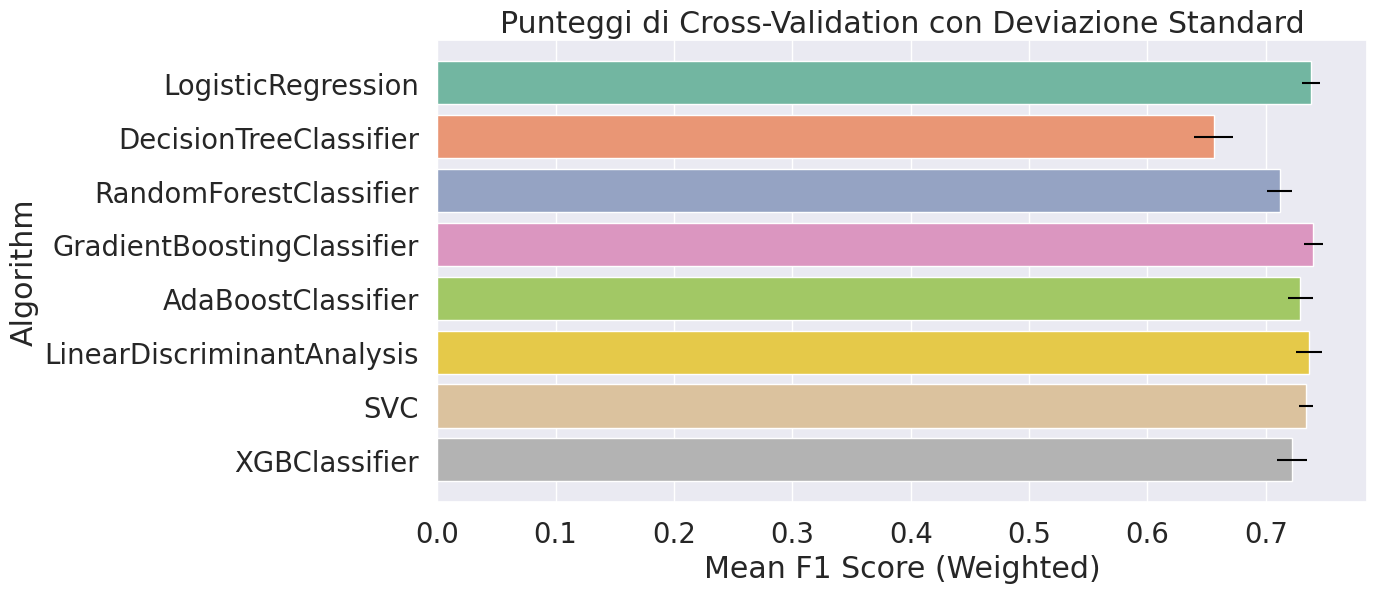

In [ ]:
# DataFrame per CV
cv_results_df = pd.DataFrame({
    "CrossValMeans": cv_acc,
    "CrossValErrors": cv_std,
    "Algorithm": clf_name
})

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_results_df, palette="Set2")
plt.errorbar(x=cv_results_df["CrossValMeans"], y=range(len(cv_results_df["Algorithm"])), xerr=cv_results_df["CrossValErrors"], fmt="none", ecolor="black", capsize=5)
plt.xlabel("Mean F1 Score (Weighted)")
plt.title("Punteggi di Cross-Validation con Deviazione Standard")
plt.show()

** Matrici di Confusione**

Visualizziamo le matrici di confusione per ogni classificatore

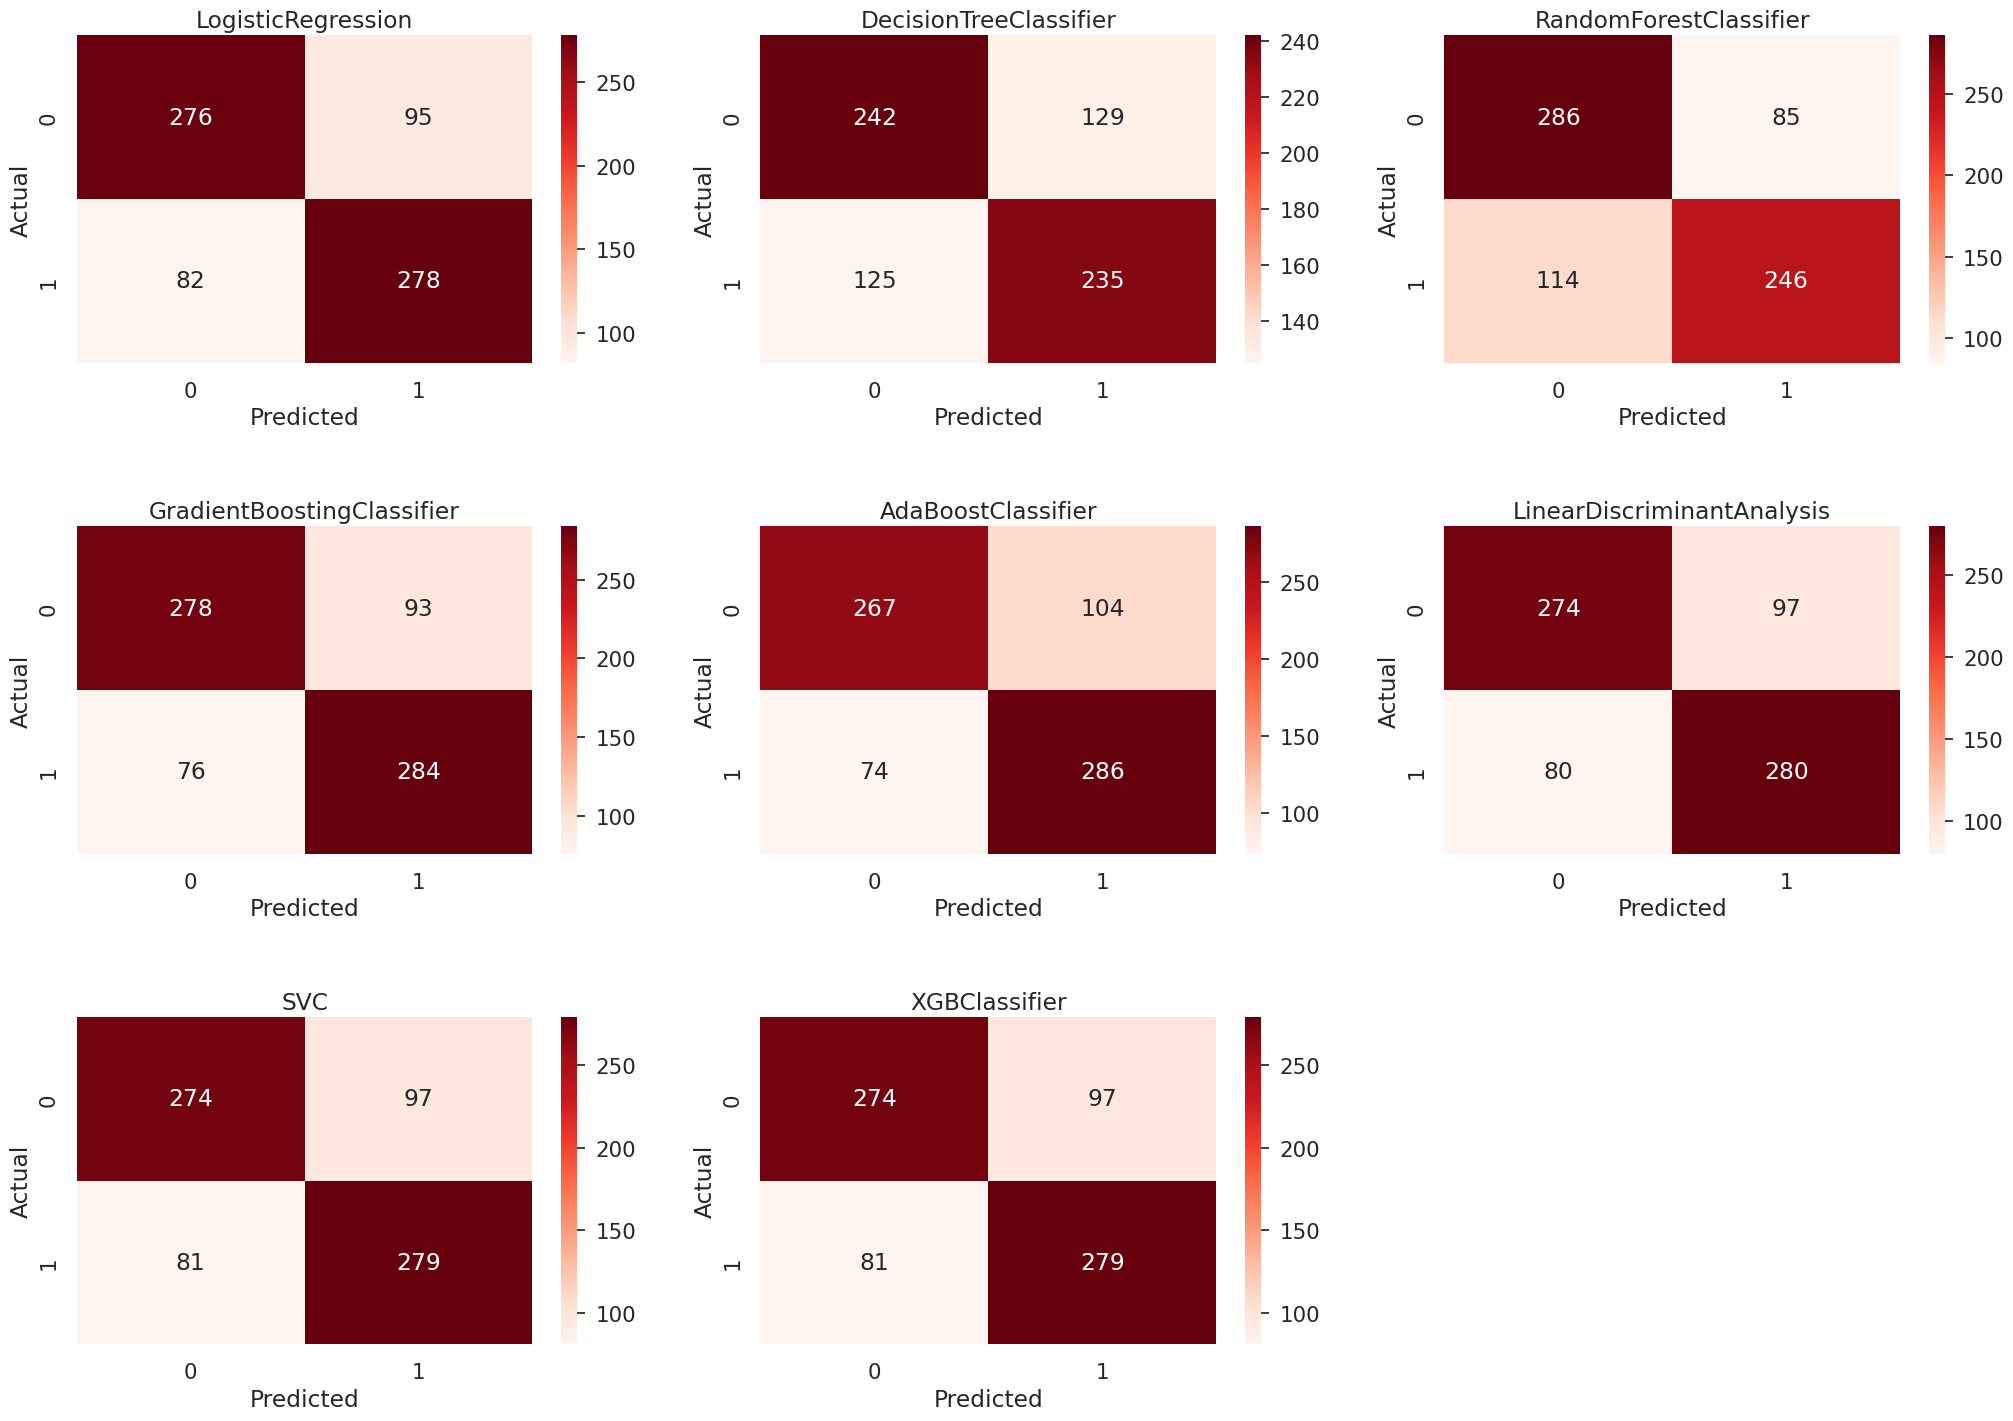

In [ ]:
# Matrici di confusione
plt.figure(figsize=(25, 17))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3, 3, i+1)
    sns.heatmap(cnfm[i], annot=True, fmt="d", cmap="Reds")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])
plt.subplots_adjust(hspace=0.5)
plt.show()

**Report di Classificazione**

Stampiamo i report di classificazione per ogni classificatore

In [ ]:
# Report
for i in range(len(classifiers)):
    print(f"{clf_name[i]} Classification Report:")
    print(clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       371
           1       0.75      0.77      0.76       360

    accuracy                           0.76       731
   macro avg       0.76      0.76      0.76       731
weighted avg       0.76      0.76      0.76       731

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       371
           1       0.65      0.65      0.65       360

    accuracy                           0.65       731
   macro avg       0.65      0.65      0.65       731
weighted avg       0.65      0.65      0.65       731

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       371
           1       0.74      0.68      0.71       360

    accuracy                           0.73     

**Curva ROC per Singoli Classificatori**

Visualizziamo la curva ROC per ogni classificatore

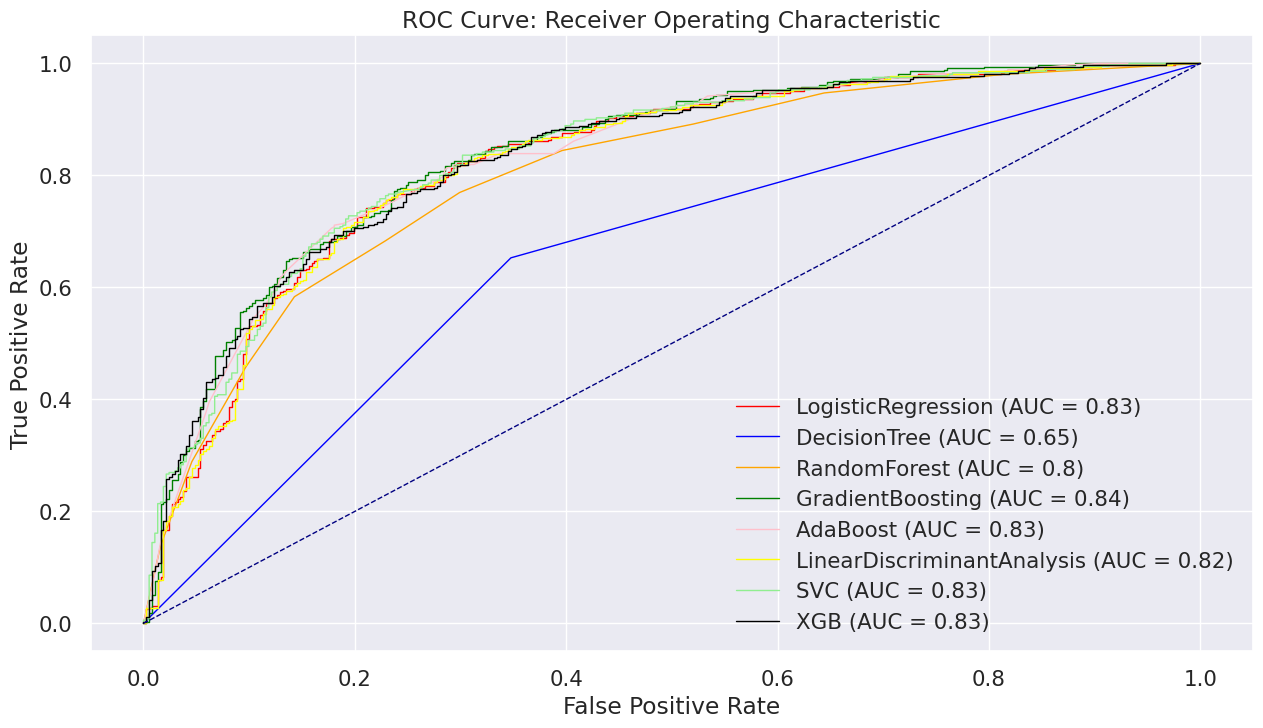

In [ ]:
# Curva ROC
plt.figure(figsize=(15, 8))
cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black']
for i in range(len(classifiers)):
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i], 2)) + ")")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Ottimizzazione degli Iperparametri**

Eseguiamo GridSearchCV per ottimizzareLogisticRegression, DecisionTree e RandomForest.

In [ ]:
# Parametri
LR_param = {
    "penalty": ["l1", "l2", None],
    "max_iter": [30, 50, 100],
    "n_jobs": [1, 3, 7],
    "C": [0.3, 0.7, 1.0],
    "fit_intercept": [True]
}
DT_param = {
    "max_depth": [2, 3, 8, 10],
    "max_features": [0.3, 0.7, 1],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "criterion": ["gini"]
}
RF_param = {
    "max_depth": [None],
    "max_features": [0.3, 0.7, 1],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion": ["gini"]
}
XGB_param = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1]
}

# GridSearch
tscv = TimeSeriesSplit(n_splits=5)
LRgs = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid=LR_param, cv=tscv, n_jobs=-1, scoring="f1_weighted", verbose=True)
DTgs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid=DT_param, cv=tscv, n_jobs=-1, scoring="f1_weighted", verbose=True)
RFgs = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid=RF_param, cv=tscv, n_jobs=-1, scoring="f1_weighted", verbose=True)
XGBgs = GridSearchCV(XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])), param_grid=XGB_param, cv=tscv, n_jobs=-1, scoring="f1_weighted", verbose=True)

models = [LRgs, DTgs, RFgs, XGBgs]
gs_model = []
score = []

for model in models:
    model.fit(X_train_res, y_train_res)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

print("Score without GridSearchCV (F1 weighted):", [float(round(x, 3)) for x in cv_acc[:3]] + [float(round(cv_acc[-1], 3))])
print("Score with GridSearchCV (F1 weighted):", [float(round(x, 3)) for x in score])

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Score without GridSearchCV (F1 weighted): [0.738, 0.656, 0.712, 0.722]
Score with GridSearchCV (F1 weighted): [0.741, 0.727, 0.747, 0.744]


**Correlazione tra Modelli**

Calcoliamo e visualizziamo la correlazione tra le predizioni dei classificatori, come nel tuo codice.

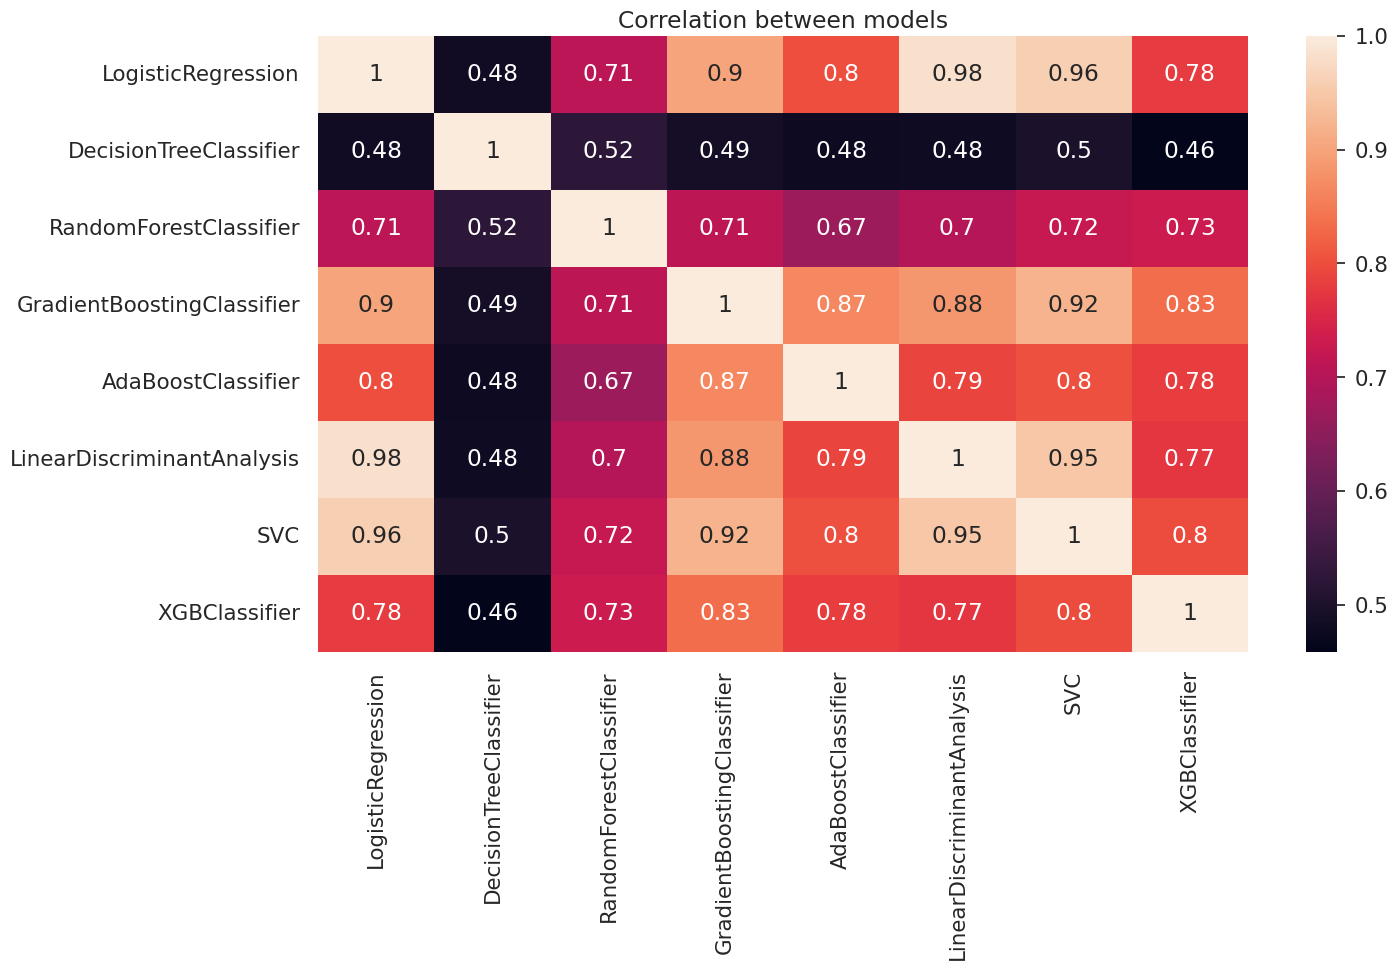

In [ ]:
# Correlazione
model_results_without_y = model_results.drop(columns=['y'])
plt.figure(figsize=(15, 8))

sns.heatmap(model_results_without_y.corr(), annot=True)
plt.title("Correlation between models")
plt.show()

**Voting Classifier**

Creiamo e addestriamo il VotingClassifier con tutti i classificatori ottimizzati.

In [ ]:
# VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('LogisticRegression', gs_model[0]),
    ('DecisionTreeClassifier', gs_model[1]),
    ('RandomForestClassifier', gs_model[2]),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=rs)),
    ('AdaBoostClassifier', AdaBoostClassifier(n_estimators=10, random_state=rs)),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
    ('SVC', SVC(probability=True, random_state=rs, class_weight='balanced')),
    ('XGBClassifier', gs_model[3])
], voting='soft')

voting_clf.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=0.3, class_weight='balanced',
                                                 max_iter=50, n_jobs=1,
                                                 penalty=None)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=8,
                                                     max_features=0.7,
                                                     min_samples_leaf=10)),
                             ('RandomForestClassifier',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     m...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

Accuracy: 0.761969904240766
F1-score (macro): 0.7619658951402821
F1-score (weighted): 0.7619511951051741

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76       371
           1       0.75      0.78      0.76       360

    accuracy                           0.76       731
   macro avg       0.76      0.76      0.76       731
weighted avg       0.76      0.76      0.76       731



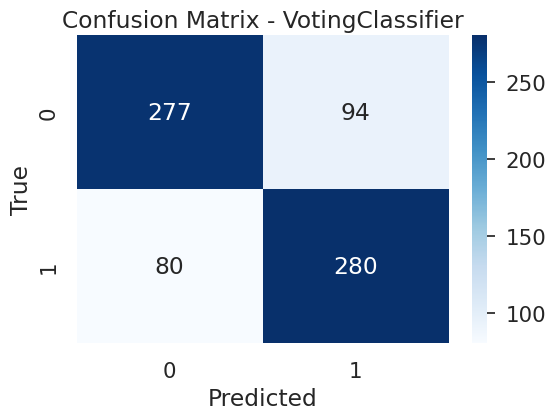

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Predizioni sul test set
y_pred = voting_clf.predict(X_test)

# 🔹 Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 🔹 F1-score (macro per classi bilanciate, weighted se sbilanciate)
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))

# 🔹 Report dettagliato
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 🔹 Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VotingClassifier")
plt.show()


**ROC Curve del Voting Classifier**

Visualizziamo la curva ROC del VotingClassifier con Yellowbrick

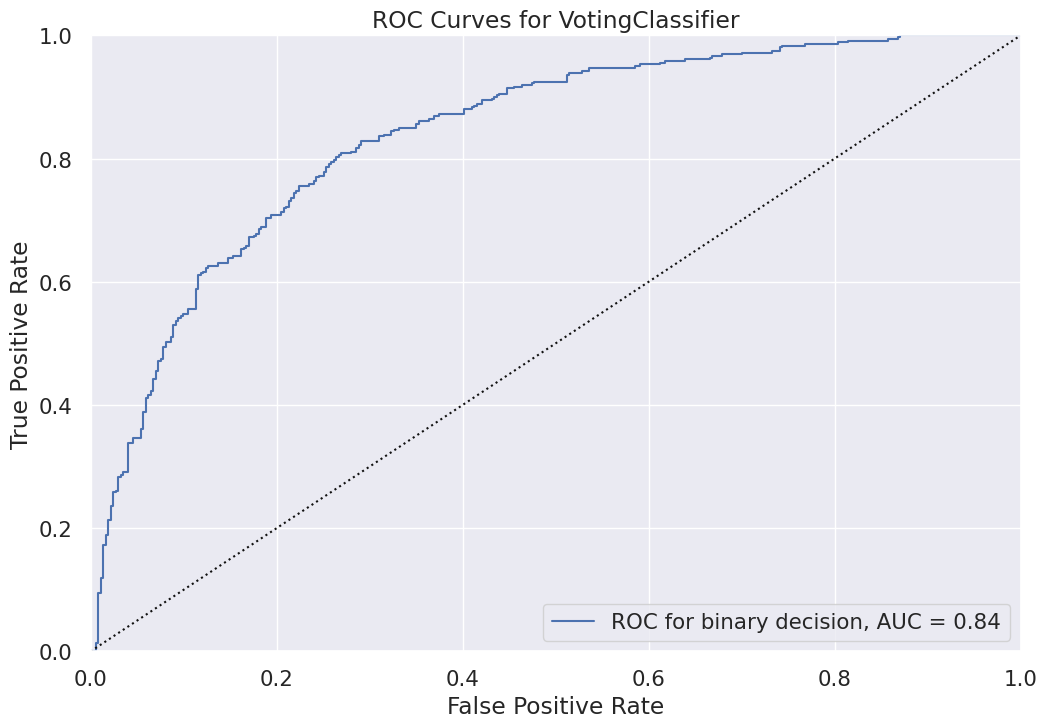

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# ROC Curve
plt.figure(figsize=(12, 8))
visualizer = ROCAUC(voting_clf, classes=["no_precipitation", "precipitation"], micro=False, macro=False, binary=True)
visualizer.fit(X_train_res, y_train_res)
visualizer.score(X_test, y_test)
visualizer.show()

**Precision-Recall Curve**

Visualizziamo la Precision-Recall Curve con Yellowbrick

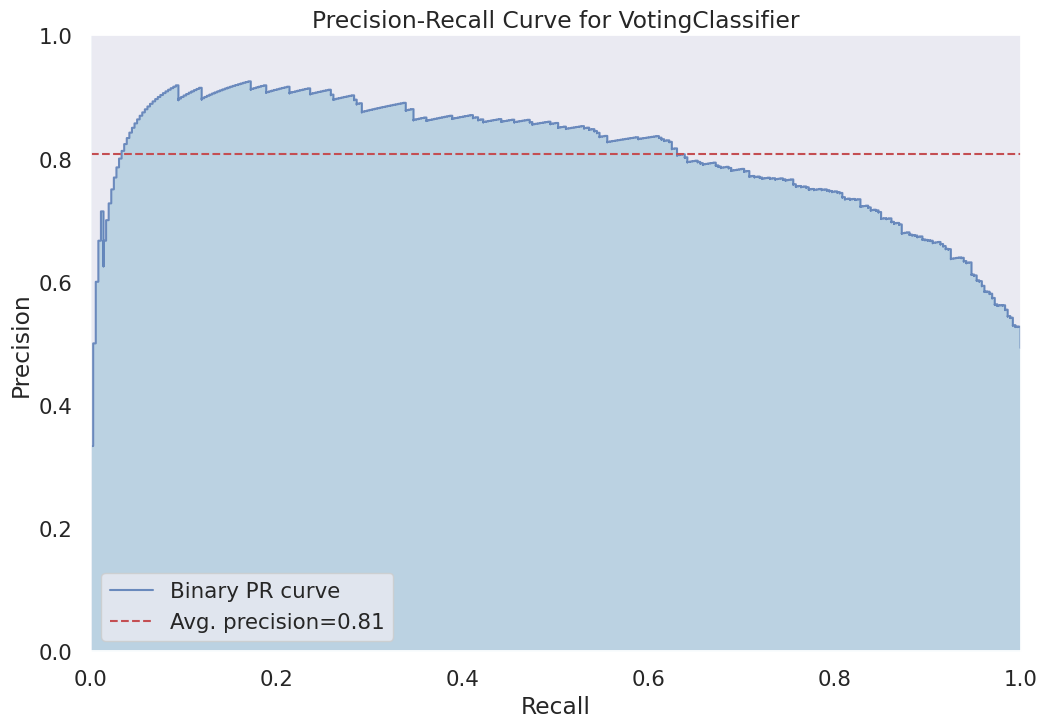

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
# Precision-Recall Curve
plt.figure(figsize=(12, 8))
viz = PrecisionRecallCurve(voting_clf)
viz.fit(X_train_res, y_train_res)
viz.score(X_test, y_test)
viz.show()

**Learning Curve**

Visualizziamo la curva di apprendimento con TimeSeriesSplit

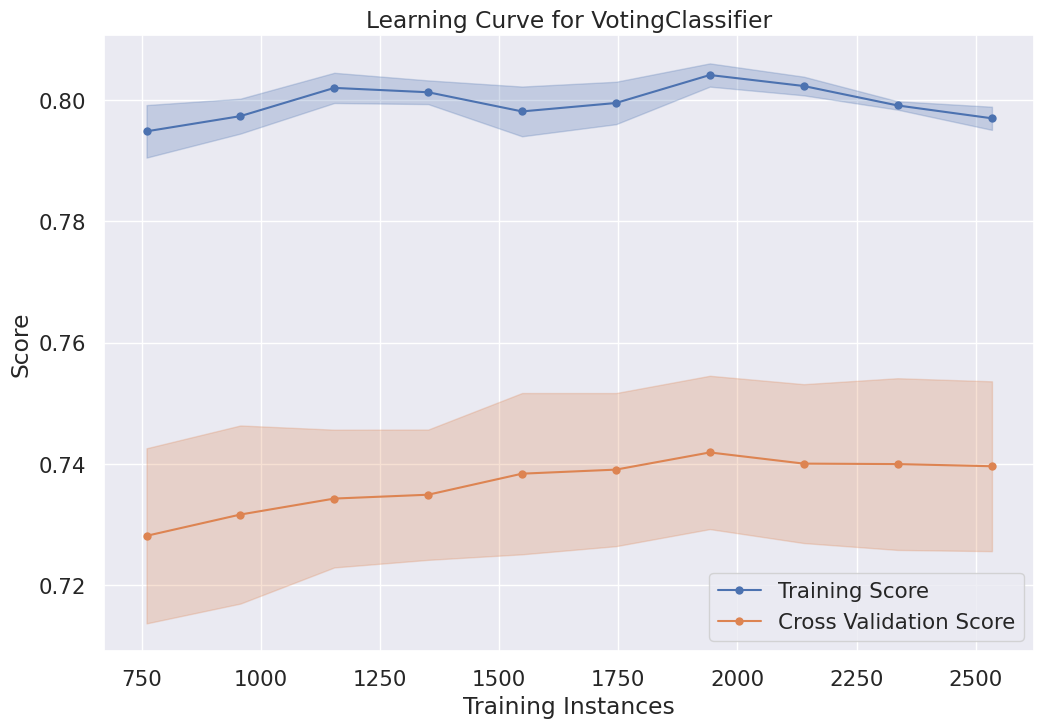

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Learning Curve
plt.figure(figsize=(12, 8))
visualizer = LearningCurve(voting_clf, cv=TimeSeriesSplit(n_splits=5), scoring='f1_weighted', train_sizes=np.linspace(0.3, 1.0, 10), n_jobs=-1)
visualizer.fit(X_train_res, y_train_res)
visualizer.show()

**Predizioni sul Dataset Completo**

Eseguiamo predizioni su tutto il dataset

In [ ]:
# Dataset completo
test_data = data.copy()
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])
x_test_final = test_data[numerical_columns]
livello_pred = pd.Series(voting_clf.predict(x_test_final), name='Livello_test')
print(livello_pred.value_counts())

Livello_test
0    7807
1    7534
Name: count, dtype: int64
